In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import keras 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
auxDic = {}
train_data_dir_sanas = '/content/drive/MyDrive/Datos5/Rosas/Rosas/Train/Sanas'
train_data_dir_enfermas = '/content/drive/MyDrive/Datos5/Rosas/Rosas/Train/Enfermas'
test_data_dir_sanas = '/content/drive/MyDrive/Datos5/Rosas/Rosas/Test/'
test_data_dir_enfermas = '/content/drive/MyDrive/Datos5/Rosas/Rosas/Test/'
validation_data_dir_sanas = '/content/drive/MyDrive/Datos5/Rosas/Rosas/Validation'
validation_data_dir_enfermas= '/content/drive/MyDrive/Datos5/Rosas/Rosas/Validation'

#enfermas
enfermas_train = os.listdir(train_data_dir_enfermas)
enfermas_test= os.listdir(test_data_dir_enfermas)
enfermas_val= os.listdir(validation_data_dir_enfermas)
for i in range(len(enfermas_train)):
  auxDic[enfermas_train[i]] = 'Enferma'
for i in range(len(enfermas_test)):
  auxDic[enfermas_test[i]] = 'Enferma'
for i in range(len(enfermas_val)):
  auxDic[enfermas_val[i]] = 'Enferma'
#Sanas
sanas_train = os.listdir(train_data_dir_sanas)
sanas_test= os.listdir(test_data_dir_sanas)
sanas_val= os.listdir(validation_data_dir_sanas)
for i in range(len(sanas_train)):
  auxDic[sanas_train[i]] = 'Sana'
for i in range(len(sanas_test)):
  auxDic[sanas_test[i]] = 'Sana'
for i in range(len(sanas_val)):
  auxDic[sanas_val[i]] = 'Sana'

df_rosas = pd.DataFrame(auxDic.items(), columns = ['Imagen','Label'])
Y = df_rosas['Label']
df_rosas

,Imagen,Label
0,IMG_1568.jpg,Enferma
1,IMG_1569.jpg,Enferma
2,IMG_1568 - copia.jpg,Enferma
3,IMG_1567.jpg,Enferma
4,IMG_1569 - copia.jpg,Enferma
...,...,...
1013,IMG_3608(1) - copia.jpg,Sana
1014,IMG_3609(1) - copia.jpg,Sana
1015,IMG_3609(1).jpg,Sana
1016,IMG_3610(1).jpg,Sana


In [ ]:
# Set up generators
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Reescalamos las imágenes
    rotation_range=10,  # Rotación aleatoria
    zoom_range=0.2,  # Zoom aleatorio
    width_shift_range=0.2,  # Traslación horizontal aleatoria
    height_shift_range=0.2,  # Traslación vertical aleatoria
    horizontal_flip=True,
    vertical_flip=True,  # Volteo horizontal aleatorio
    preprocessing_function=preprocess_input, 
    fill_mode='nearest',
    data_format="channels_last")


test_datagen = ImageDataGenerator(
    rescale=1./255,  # Reescalamos las imágenes
    rotation_range=10,  # Rotación aleatoria
    zoom_range=0.2,  # Zoom aleatorio
    width_shift_range=0.2,  # Traslación horizontal aleatoria
    height_shift_range=0.2,  # Traslación vertical aleatoria
    horizontal_flip=True,
    vertical_flip=True,  # Volteo horizontal aleatorio
    preprocessing_function=preprocess_input, 
    fill_mode='nearest',
    data_format="channels_last")

valid_datagen = ImageDataGenerator(
    rescale=1./255,  # Reescalamos las imágenes
    rotation_range=10,  # Rotación aleatoria
    zoom_range=0.2,  # Zoom aleatorio
    width_shift_range=0.2,  # Traslación horizontal aleatoria
    height_shift_range=0.2,  # Traslación vertical aleatoria
    horizontal_flip=True,
    vertical_flip=True,  # Volteo horizontal aleatorio
    preprocessing_function=preprocess_input, 
    fill_mode='nearest',
    data_format="channels_last")

#Modelo

In [ ]:
from keras.layers import Dense, Flatten 
from keras.models import Model 
base_model = VGG19(input_shape= (255, 255, 3), weights='imagenet', include_top= False)
for layer in base_model.layers:
  layer.trainable = False
X = Flatten()(base_model.output)
X = Dense(units=64, activation='relu')(X)
prediction= Dense(2, activation= 'sigmoid')(X)
model = Model(base_model.input, outputs= prediction)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0   

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es = EarlyStopping(monitor = 'val_loss', patience = 20, verbose= 1)

mc = ModelCheckpoint(filepath= 'best_model.h5', 
                     monitor = 'val_loss', 
                     #min_delta = 0.01, 
                     patience = 20, 
                     verbose=1, 
                     save_best_only= True)

cb= [es, mc]

#Entrenamiento

-------------- FOLD 1 -------------
204 images for test
691 images for training
123 images for validation
Found 691 validated image filenames belonging to 2 classes.
Found 123 validated image filenames belonging to 2 classes.
Found 202 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="Imagen". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.0889 - accuracy: 0.5630
Epoch 1: val_loss improved from inf to 0.70364, saving model to model6VGG19.h5
21/21 [==============================] - 84s 4s/step - loss: 1.0889 - accuracy: 0.5630 - val_loss: 0.7036 - val_accuracy: 0.5000
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.6453 - accuracy: 0.6343
Epoch 2: val_loss improved from 0.70364 to 0.60595, saving model to model6VGG19.h5
21/21 [==============================] - 80s 4s/step - loss: 0.6453 - accuracy: 0.6343 - val_loss: 0.6059 - val_accuracy: 0.7708
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.5795 - accuracy: 0.7420
Epoch 3: val_loss improved from 0.60595 to 0.55167, saving model to model6VGG19.h5
21/21 [==============================] - 81s 4s/step - loss: 0.5795 - accuracy: 0.7420 - val_loss: 0.5517 - val_accuracy: 0.7708
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.5661 - accuracy:

202/202 [==============================] - 20s 84ms/step
ACCURACY FOLD 1= 50.5%
Accuracy: [50.5]
Precision: [50.0]
Recall: [59.0]
F1 Score: [54.13]


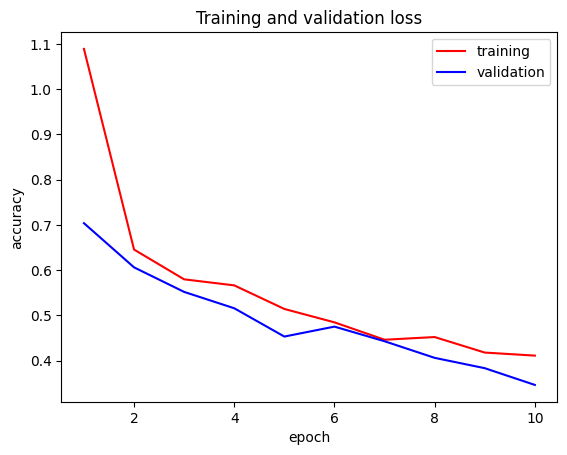

-------------- FOLD 2 -------------
204 images for test
691 images for training
123 images for validation
Found 690 validated image filenames belonging to 2 classes.
Found 122 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Imagen". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Imagen". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.4053 - accuracy: 0.8252
Epoch 1: val_loss did not improve from 0.34601
21/21 [==============================] - 83s 4s/step - loss: 0.4053 - accuracy: 0.8252 - val_loss: 0.3586 - val_accuracy: 0.8854
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.3668 - accuracy: 0.8378
Epoch 2: val_loss did not improve from 0.34601
21/21 [==============================] - 81s 4s/step - loss: 0.3668 - accuracy: 0.8378 - val_loss: 0.3801 - val_accuracy: 0.8646
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.3656 - accuracy: 0.8495
Epoch 3: val_loss improved from 0.34601 to 0.27898, saving model to model6VGG19.h5
21/21 [==============================] - 79s 4s/step - loss: 0.3656 - accuracy: 0.8495 - val_loss: 0.2790 - val_accuracy: 0.9062
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.3329 - accuracy: 0.8708
Epoch 4: val_loss improved from 0.27898 to 0.25322, saving m

204/204 [==============================] - 21s 87ms/step
ACCURACY FOLD 2= 53.43%
Accuracy: [50.5, 53.43]
Precision: [50.0, 52.8]
Recall: [59.0, 64.71]
F1 Score: [54.13, 58.15]


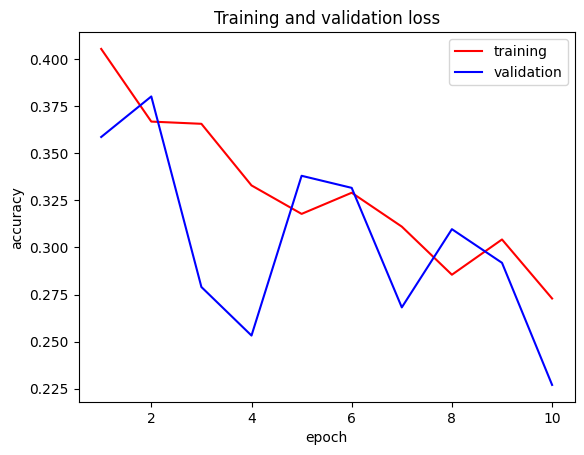

-------------- FOLD 3 -------------
204 images for test
691 images for training
123 images for validation
Found 690 validated image filenames belonging to 2 classes.
Found 122 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Imagen". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Imagen". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.8708
Epoch 1: val_loss did not improve from 0.22702
21/21 [==============================] - 84s 4s/step - loss: 0.3237 - accuracy: 0.8708 - val_loss: 0.2881 - val_accuracy: 0.8854
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.8997
Epoch 2: val_loss did not improve from 0.22702
21/21 [==============================] - 79s 4s/step - loss: 0.2818 - accuracy: 0.8997 - val_loss: 0.2575 - val_accuracy: 0.9167
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.2655 - accuracy: 0.8967
Epoch 3: val_loss did not improve from 0.22702
21/21 [==============================] - 79s 4s/step - loss: 0.2655 - accuracy: 0.8967 - val_loss: 0.3406 - val_accuracy: 0.8646
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.8875
Epoch 4: val_loss did not improve from 0.22702
21/21 [==============================] - 79s 4s/s

204/204 [==============================] - 21s 88ms/step
ACCURACY FOLD 3= 57.35%
Accuracy: [50.5, 53.43, 57.35]
Precision: [50.0, 52.8, 57.01]
Recall: [59.0, 64.71, 59.8]
F1 Score: [54.13, 58.15, 58.37]


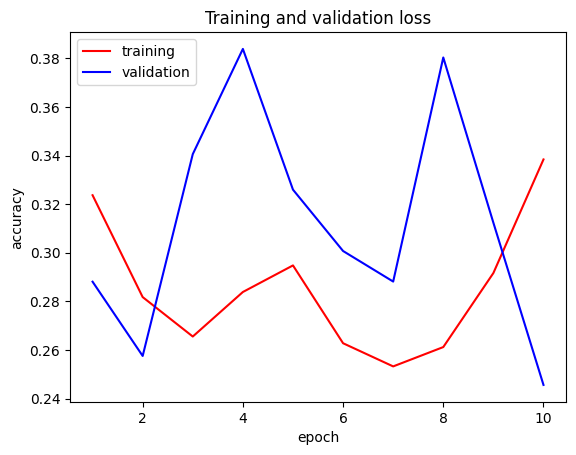

-------------- FOLD 4 -------------
203 images for test
692 images for training
123 images for validation
Found 691 validated image filenames belonging to 2 classes.
Found 122 validated image filenames belonging to 2 classes.
Found 203 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Imagen". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Imagen". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.3002 - accuracy: 0.8771
Epoch 1: val_loss did not improve from 0.22702
21/21 [==============================] - 84s 4s/step - loss: 0.3002 - accuracy: 0.8771 - val_loss: 0.3048 - val_accuracy: 0.8958
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.2267 - accuracy: 0.9122
Epoch 2: val_loss did not improve from 0.22702
21/21 [==============================] - 81s 4s/step - loss: 0.2267 - accuracy: 0.9122 - val_loss: 0.2704 - val_accuracy: 0.9062
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9181
Epoch 3: val_loss did not improve from 0.22702
21/21 [==============================] - 79s 4s/step - loss: 0.2283 - accuracy: 0.9181 - val_loss: 0.2826 - val_accuracy: 0.8854
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9105
Epoch 4: val_loss did not improve from 0.22702
21/21 [==============================] - 80s 4s/s

203/203 [==============================] - 21s 88ms/step
ACCURACY FOLD 4= 49.26%
Accuracy: [50.5, 53.43, 57.35, 49.26]
Precision: [50.0, 52.8, 57.01, 49.54]
Recall: [59.0, 64.71, 59.8, 52.94]
F1 Score: [54.13, 58.15, 58.37, 51.18]


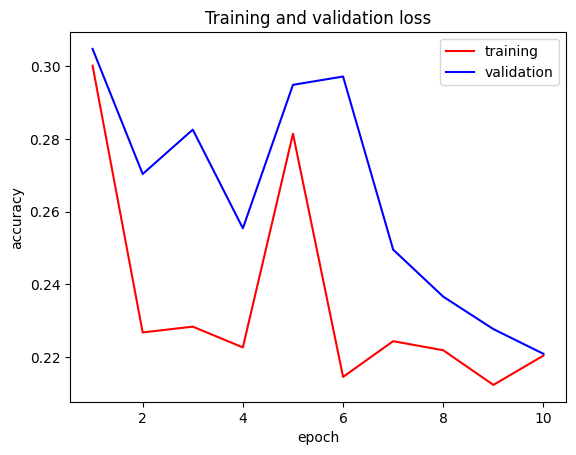

-------------- FOLD 5 -------------
203 images for test
692 images for training
123 images for validation
Found 691 validated image filenames belonging to 2 classes.
Found 122 validated image filenames belonging to 2 classes.
Found 203 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Imagen". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="Imagen". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8801
Epoch 1: val_loss did not improve from 0.22085
21/21 [==============================] - 84s 4s/step - loss: 0.2792 - accuracy: 0.8801 - val_loss: 0.2287 - val_accuracy: 0.9271
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.9226
Epoch 2: val_loss did not improve from 0.22085
21/21 [==============================] - 79s 4s/step - loss: 0.2249 - accuracy: 0.9226 - val_loss: 0.2313 - val_accuracy: 0.8958
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9044
Epoch 3: val_loss did not improve from 0.22085
21/21 [==============================] - 79s 4s/step - loss: 0.2474 - accuracy: 0.9044 - val_loss: 0.2549 - val_accuracy: 0.9271
Epoch 4/10
21/21 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9150
Epoch 4: val_loss did not improve from 0.22085
21/21 [==============================] - 79s 4s/s

203/203 [==============================] - 21s 88ms/step
ACCURACY FOLD 5= 53.2%
Accuracy: [50.5, 53.43, 57.35, 49.26, 53.2]
Precision: [50.0, 52.8, 57.01, 49.54, 53.54]
Recall: [59.0, 64.71, 59.8, 52.94, 51.96]
F1 Score: [54.13, 58.15, 58.37, 51.18, 52.74]


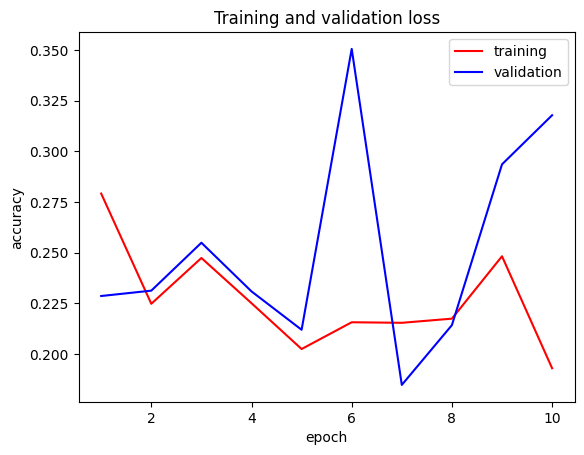

ACCURACY AVERAGE TOTAL OF THE MODEL: 52.748000000000005


In [ ]:
from sklearn.model_selection import train_test_split
RSEED = 3
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
F1=[]
PREDICCIONES=[]
PRESICION=[]
RECALL=[]
PERDIDA=[]
VAL_PERDIDA=[]
INDICES=[]
ACCURACY_ALL=[]
skf = StratifiedKFold(n_splits = 5, random_state = RSEED, shuffle = True)
image_dir = '/content/drive/MyDrive/base_Rosas'
fold_var = 1

for train_index, test_index in skf.split(np.zeros(len(Y)),Y):
    print("-------------- FOLD "+str(fold_var)+" -------------")
    temp_data = df_rosas.iloc[train_index] 
    test_data = df_rosas.iloc[test_index] 
    print(str(len(test_data)) + " images for test")

    aunxX = temp_data["Imagen"]
    aunxY = temp_data["Label"] 

    X_train, X_val, y_train, y_val = train_test_split(aunxX, aunxY, stratify=aunxY,test_size=0.15, random_state=42)

    training_data = pd.concat([X_train, y_train], axis=1) # dataframe TRAINING
    print(str(len(training_data)) + " images for training")
    validation_data = pd.concat([X_val, y_val], axis=1) # dataframe to VALIDATION
    print(str(len(validation_data)) + " images for validation")

    train_data_generator = train_datagen.flow_from_dataframe(
        dataframe=training_data,
        directory=image_dir,
        x_col="Imagen",
        y_col="Label",
        target_size=(255, 255),
        batch_size=32,
        subset='training',
        shuffle=True,
        seed=42)
    validation_data_generator = train_datagen.flow_from_dataframe(
        dataframe=validation_data,
        directory=image_dir,
        x_col="Imagen",
        y_col="Label",
        target_size=(255, 255),
        batch_size=32,
        subset='training',
        shuffle=True,
        seed=42)
    test_data_generator = train_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory=image_dir,
        x_col="Imagen",
        y_col="Label",
        target_size=(255, 255),
        batch_size=32,
        subset='training',
        shuffle=True,
        seed=42)
    
    #Steps
    train_steps = train_data_generator.n//train_data_generator.batch_size
    val_steps = validation_data_generator.n//validation_data_generator.batch_size
    test_steps =test_data_generator.n
    
    #Modelo
    model.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    his = model.fit(train_data_generator,
                          steps_per_epoch=train_steps,
                          validation_data=validation_data_generator,
                          validation_steps=val_steps,
                          epochs= 10,
                          verbose= 1,
                          callbacks=cb)
    
    #Metricas
    predictions = model.predict(test_data_generator, steps=test_steps, verbose=1) 
    PREDICCIONES.append(predictions)
    test_labels = test_data_generator.classes
    ACCURACY_ALL.append(round(accuracy_score(test_labels, predictions.argmax(axis=1))*100,2))
    print("ACCURACY FOLD "+str(fold_var)+"= "+ str(round(accuracy_score(test_labels, predictions.argmax(axis=1))*100,2))+"%")
    loss = his.history['loss']
    val_loss = his.history['val_loss']

    PRESICION.append(round(precision_score(test_labels, predictions.argmax(axis=1))*100,2))
    RECALL.append(round(recall_score(test_labels, predictions.argmax(axis=1))*100,2))
    F1.append(round(f1_score(test_labels, predictions.argmax(axis=1))*100,2))
    PERDIDA.append(loss)
    VAL_PERDIDA.append(val_loss)

    print('Accuracy:', ACCURACY_ALL)
    print('Precision:', PRESICION)
    print('Recall:', RECALL)
    print('F1 Score:', F1)

    #Graficos
    # validation vs epocas
    plt.plot(range(1, len(loss) + 1), loss, 'r')
    plt.plot(range(1, len(val_loss) + 1), val_loss, 'b')
    plt.title('Training and validation loss')
    #plt.ylim(0,0.5)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    fold_var +=1
print("ACCURACY AVERAGE TOTAL OF THE MODEL: "+str(np.mean(ACCURACY_ALL)))

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.models import load_model


model = load_model("/content/drive/MyDrive/PI/best_model.h5")

1/1 [==============================] - 7s 7s/step
preds[0]: [0. 1. 0.]
Enferma 100.0 %


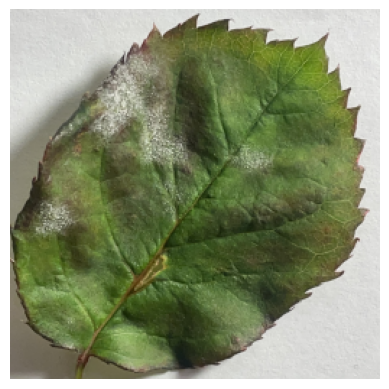

In [10]:
names = ['Sana','Enferma']
modelt = load_model("/content/drive/MyDrive/PI/best_model.h5")
imaget_path = "/content/drive/MyDrive/base_Rosas/IMG_2326.jpg"
img = cv2.imread(imaget_path)
imaget = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print('preds[0]:',preds[0])   # ... tiene las probabilidades por cada clase ...
print(names[np.argmax(preds)],preds[0][np.argmax(preds)]*100.0,'%')
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 150ms/step
preds[0]: [0. 1. 0.]
Enferma 100.0 %


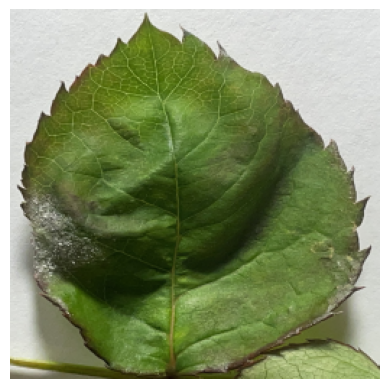

In [11]:
names = ['Sana','Enferma']
modelt = load_model("/content/drive/MyDrive/PI/best_model.h5")
imaget_path = "/content/drive/MyDrive/base_Rosas/IMG_2328.jpg"
img = cv2.imread(imaget_path)
imaget = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print('preds[0]:',preds[0])   # ... tiene las probabilidades por cada clase ...
print(names[np.argmax(preds)],preds[0][np.argmax(preds)]*100.0,'%')
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 149ms/step
preds[0]: [0. 1. 0.]
Enferma 100.0 %


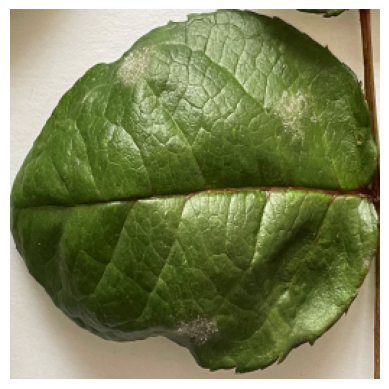

In [21]:
names = ['Sana','Enferma']
modelt = load_model("/content/drive/MyDrive/PI/best_model.h5")
imaget_path = "/content/drive/MyDrive/base_Rosas/IMG_2906.jpg"
img = cv2.imread(imaget_path)
imaget = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print('preds[0]:',preds[0])   # ... tiene las probabilidades por cada clase ...
print(names[np.argmax(preds)],preds[0][np.argmax(preds)]*100.0,'%')
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 150ms/step
preds[0]: [0. 1. 0.]
Sana 100.0 %


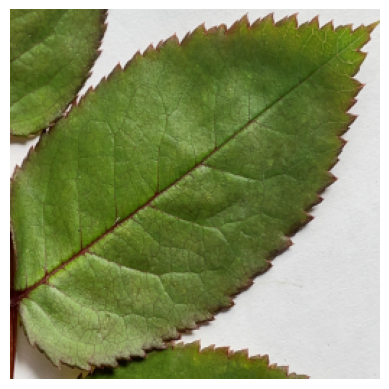

In [26]:
names = ['Enferma','Sana']
modelt = load_model("/content/drive/MyDrive/PI/best_model.h5")
imaget_path = "/content/drive/MyDrive/base_Rosas/IMG_3517.jpg"
img = cv2.imread(imaget_path)
imaget = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
xt = np.asarray(imaget)
xt=preprocess_input(xt)
xt = np.expand_dims(xt,axis=0)
preds = modelt.predict(xt)

print('preds[0]:',preds[0])   # ... tiene las probabilidades por cada clase ...
print(names[np.argmax(preds)],preds[0][np.argmax(preds)]*100.0,'%')
plt.imshow(cv2.cvtColor(np.asarray(imaget),cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()